1392778 - Izumi Alatriste

Random Forest (UNIGRAMS) Deceptive Opinion Spam (v1.4)
- Train/tune on folds 1–4 and evaluate on fold 5
- Vectorization
- Outputs metrics, top terms, predictions

In [1]:
from pathlib import Path
import argparse, zipfile, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
from scipy import sparse

In [2]:
LABEL_MAP = {"truthful_from_Web": 1, "deceptive_from_MTurk": 0} 
POLS = {"negative_polarity"}  
CLASS_NAMES = {0: "deceptive", 1: "truthful"}

In [3]:
def iter_review_files(data_path: Path):
    root = data_path / "op_spam_v1.4" if (data_path / "op_spam_v1.4").is_dir() else data_path
    if zipfile.is_zipfile(root):
        with zipfile.ZipFile(root) as z:
            for n in z.namelist():
                if not n.endswith(".txt"):
                    continue
                parts = Path(n).parts
                if parts and parts[0].lower().startswith("op_spam"):
                    parts = parts[1:]
                if len(parts) < 5:
                    continue
                pol, lab, fold = parts[0], parts[1], parts[2]
                if pol not in POLS or lab not in LABEL_MAP or not fold.startswith("fold"):
                    continue
                text = z.read(n).decode("utf-8", "ignore")
                yield "/".join(parts), text, pol, lab, int(fold[4:]), LABEL_MAP[lab]
    else:
        for pol in POLS:
            for lab, y in LABEL_MAP.items():
                p = root / pol / lab
                if not p.exists():
                    continue
                for fd in sorted(p.glob("fold*")):
                    m = re.fullmatch(r"fold(\d+)", fd.name)
                    if not m:
                        continue
                    fold_int = int(m.group(1))
                    for txt in fd.glob("*.txt"):
                        parts = [root.name, pol, lab, fd.name, txt.name]
                        yield "/".join(parts), txt.read_text(encoding="utf-8", errors="ignore"), pol, lab, fold_int, y

In [4]:
def load_dataframe(data_path: Path) -> pd.DataFrame:
    rows = []
    for rel_path, text, pol, lab, fold, y in iter_review_files(data_path):
        rows.append({"fold": fold, "label": y, "text": text, "path": rel_path})
    if not rows:
        raise RuntimeError("No reviews found. Check --data path and dataset layout.")
    df = pd.DataFrame(rows).sort_values(["fold", "label"]).reset_index(drop=True)
    # quick summary
    n = len(df)
    n_true = int(df["label"].sum())
    n_fake = n - n_true
    folds = sorted(df["fold"].unique().tolist())
    print(f"[load_dataframe] Loaded {n} reviews | truthful={n_true}, deceptive={n_fake} | folds={folds}", flush=True)
    return df


In [5]:
def vectorize_and_select(Xtr_text, Xte_text, ytr, k=3000, ngram=(1, 1), min_df=2):
    vec = CountVectorizer(ngram_range=ngram, min_df=min_df)
    Xtr = vec.fit_transform(Xtr_text)
    Xte = vec.transform(Xte_text)

    n_feats = Xtr.shape[1]
    if k is None or k <= 0 or k >= n_feats:
        sel = None
        Xtr_sel, Xte_sel = Xtr, Xte
        feature_names = vec.get_feature_names_out()
    else:
        sel = SelectKBest(score_func=chi2, k=k)
        Xtr_sel = sel.fit_transform(Xtr, ytr)
        Xte_sel = sel.transform(Xte)
        feature_names = np.array(vec.get_feature_names_out())[sel.get_support()]

    return Xtr_sel, Xte_sel, feature_names

In [6]:
def tune_rf_oob(X, y):
    grid = {
        "n_estimators": [300, 600],
        "max_features": ["sqrt", 0.1],
        "max_depth": [None, 40],
        "min_samples_leaf": [1, 2],
    }
    best = None
    for n in grid["n_estimators"]:
        for mf in grid["max_features"]:
            for md in grid["max_depth"]:
                for mleaf in grid["min_samples_leaf"]:
                    clf = RandomForestClassifier(
                        n_estimators=n, max_features=mf, max_depth=md,
                        min_samples_leaf=mleaf, bootstrap=True, oob_score=True,
                        n_jobs=-1, random_state=42
                    )
                    clf.fit(X, y)
                    score = float(clf.oob_score_)
                    if best is None or score > best["oob"]:
                        best = {"model": clf, "oob": score,
                                "params": dict(n_estimators=n, max_features=mf, max_depth=md, min_samples_leaf=mleaf)}
    print(f"[tune_rf_oob] Best OOB={best['oob']:.4f} with {best['params']}")
    return best

In [8]:
def eval_on_test(model, Xte, yte):
    ypred = model.predict(Xte)
    acc = accuracy_score(yte, ypred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        yte, ypred, average="binary", pos_label=1, zero_division=0
    )
    print(f"[Test] acc={acc:.4f}  precision={prec:.4f}  recall={rec:.4f}  f1={f1:.4f}", flush=True)
    return {"acc": acc, "precision": prec, "recall": rec, "f1": f1, "y_pred": ypred}

In [9]:
def directional_top_terms(model, Xtr, ytr, feature_names, topk=10):
    imp = np.asarray(getattr(model, "feature_importances_", np.zeros(len(feature_names))))
    Xbin = Xtr.copy().tocsr(); Xbin.data = np.ones_like(Xbin.data)
    idx1 = np.where(ytr == 1)[0]; idx0 = np.where(ytr == 0)[0]
    p1 = np.asarray(Xbin[idx1].mean(axis=0)).ravel()
    p0 = np.asarray(Xbin[idx0].mean(axis=0)).ravel()
    direction = p1 - p0
    signed = imp * direction
    idx_genuine = np.argsort(-signed)[:topk]
    idx_fake = np.argsort(signed)[:topk]
    top_genuine = [(feature_names[i], float(imp[i]), float(direction[i])) for i in idx_genuine]
    top_fake = [(feature_names[i], float(imp[i]), float(direction[i])) for i in idx_fake]
    return top_fake, top_genuine

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, learning_curve

def save_classification_report(y_true, y_pred, out_dir: Path, fname="rf_uni_classification_report.txt"):
    target_names = [CLASS_NAMES[0], CLASS_NAMES[1]]
    report_txt = classification_report(
        y_true, y_pred, labels=[0, 1], target_names=target_names, digits=4, zero_division=0
    )
    out = out_dir / fname
    out.write_text(report_txt, encoding="utf-8")
    print("\nClassification report:\n")
    print(report_txt)
    print(f"[saved] {out}")

def plot_and_save_confusion(y_true, y_pred, out_dir: Path, base="rf_uni_confusion", show=True):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    pd.DataFrame(cm, index=[CLASS_NAMES[0], CLASS_NAMES[1]],
                 columns=[CLASS_NAMES[0], CLASS_NAMES[1]]).to_csv(out_dir / f"{base}_counts.csv")

    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[CLASS_NAMES[0], CLASS_NAMES[1]]).plot(
        ax=ax, values_format="d", colorbar=False
    )
    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    fig.savefig(out_dir / f"{base}_counts.png", dpi=150)
    if show: plt.show()
    plt.close(fig)

    cm_norm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")
    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[CLASS_NAMES[0], CLASS_NAMES[1]]).plot(
        ax=ax, values_format=".2f", colorbar=False
    )
    ax.set_title("Confusion Matrix (Normalized)")
    fig.tight_layout()
    fig.savefig(out_dir / f"{base}_normalized.png", dpi=150)
    if show: plt.show()
    plt.close(fig)

    print(f"[saved] {out_dir / f'{base}_counts.png'}")
    print(f"[saved] {out_dir / f'{base}_counts.csv'}")
    print(f"[saved] {out_dir / f'{base}_normalized.png'}")

def plot_prob_histogram(model, X, out_dir: Path, base="rf_uni_prob_hist", bins=20, show=True):
    if not hasattr(model, "predict_proba"):
        print("[warn] Model has no predict_proba; skipping probability histogram.")
        return
    probs = model.predict_proba(X)[:, 1]
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(probs, bins=bins, edgecolor="black")
    ax.set_title("Predicted Probabilities (class=1)")
    ax.set_xlabel("P(y=1)")
    ax.set_ylabel("Count")
    fig.tight_layout()
    out_png = out_dir / f"{base}.png"
    fig.savefig(out_png, dpi=150)
    if show: plt.show()
    plt.close(fig)
    pd.DataFrame({"proba_pos": probs}).to_csv(out_dir / f"{base}.csv", index=False)
    print(f"[saved] {out_png}")
    print(f"[saved] {out_dir / f'{base}.csv'}")

def plot_precision_recall(y_true, y_scores, out_dir: Path, base="rf_uni_pr", show=True):
    if len(np.unique(y_true)) < 2:
        print("[PR] Only one class present in y_true; skipping PR curve.")
        return
    prec, rec, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(rec, prec)
    ax.set_title(f"Precision–Recall Curve (AP={ap:.4f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.grid(True)
    fig.tight_layout()
    out_png = out_dir / f"{base}.png"
    fig.savefig(out_png, dpi=150)
    if show: plt.show()
    plt.close(fig)
    pd.DataFrame({"recall": rec, "precision": prec}).to_csv(out_dir / f"{base}.csv", index=False)
    print(f"[saved] {out_png}")
    print(f"[saved] {out_dir / f'{base}.csv'}")

def plot_learning_curve_estimator(estimator, X, y, out_dir: Path, base="rf_uni_learning_curve", show=True):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_sizes = np.linspace(0.1, 1.0, 5)
    sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, shuffle=True, random_state=42
    )
    train_mean = train_scores.mean(axis=1); train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1);     val_std = val_scores.std(axis=1)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(sizes, train_mean, marker="o", label="Train")
    ax.fill_between(sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
    ax.plot(sizes, val_mean, marker="s", label="CV")
    ax.fill_between(sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
    ax.set_title("Learning Curve (accuracy)")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend()
    ax.grid(True)
    fig.tight_layout()
    out_png = out_dir / f"{base}.png"
    fig.savefig(out_png, dpi=150)
    if show: plt.show()
    plt.close(fig)
    pd.DataFrame({
        "train_size": sizes,
        "train_mean": train_mean, "train_std": train_std,
        "cv_mean": val_mean,     "cv_std": val_std
    }).to_csv(out_dir / f"{base}.csv", index=False)
    print(f"[saved] {out_png}")
    print(f"[saved] {out_dir / f'{base}.csv'}")


Mode: FOLDER | Root=/home/izujia/Desktop/Data Mining/AssigmentFiles/RF_GB/op_spam_v1.4 | Polarity subset=['negative_polarity']
[load_dataframe] Loaded 800 reviews | truthful=400, deceptive=400 | folds=[1, 2, 3, 4, 5]
[tune_rf_oob] Best OOB=0.8469 with {'n_estimators': 600, 'max_features': 'sqrt', 'max_depth': None, 'min_samples_leaf': 2}
[Test] acc=0.8562  precision=0.8202  recall=0.9125  f1=0.8639

Classification report:

              precision    recall  f1-score   support

   deceptive     0.9014    0.8000    0.8477        80
    truthful     0.8202    0.9125    0.8639        80

    accuracy                         0.8562       160
   macro avg     0.8608    0.8562    0.8558       160
weighted avg     0.8608    0.8562    0.8558       160

[saved] rf_uni_outputs/rf_uni_classification_report.txt


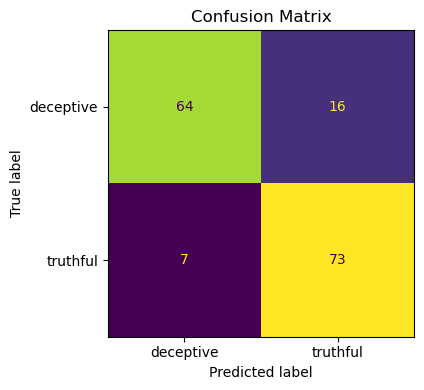

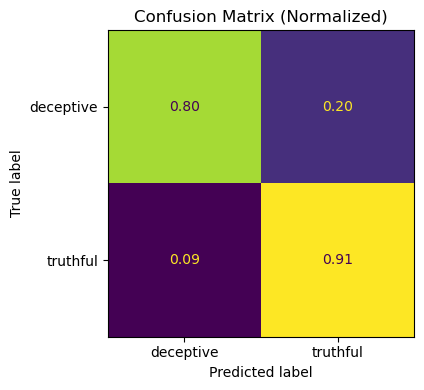

[saved] rf_uni_outputs/rf_uni_confusion_counts.png
[saved] rf_uni_outputs/rf_uni_confusion_counts.csv
[saved] rf_uni_outputs/rf_uni_confusion_normalized.png


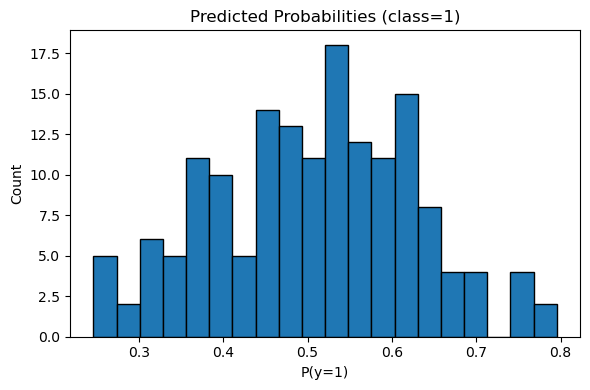

[saved] rf_uni_outputs/rf_uni_prob_hist.png
[saved] rf_uni_outputs/rf_uni_prob_hist.csv


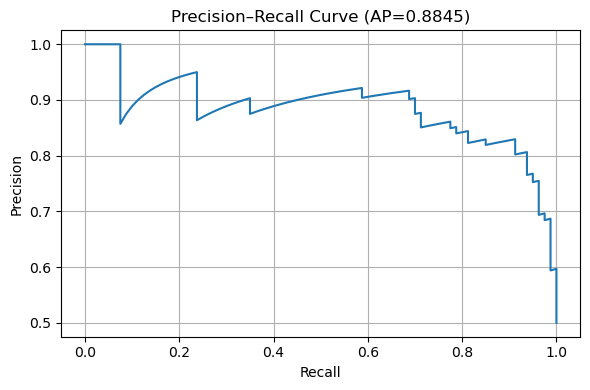

[saved] rf_uni_outputs/rf_uni_pr.png
[saved] rf_uni_outputs/rf_uni_pr.csv


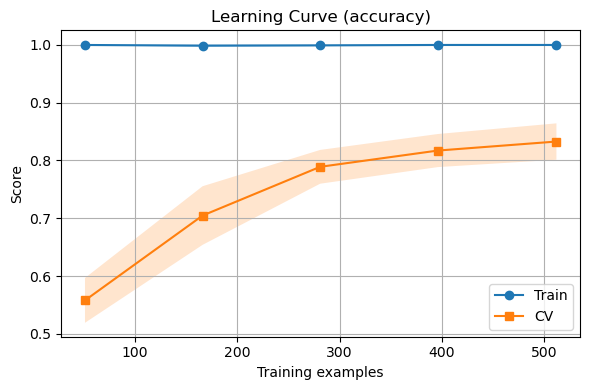

[saved] rf_uni_outputs/rf_uni_learning_curve.png
[saved] rf_uni_outputs/rf_uni_learning_curve.csv
        Model    acc  precision  recall     f1    OOB
RF (unigrams) 0.8562     0.8202  0.9125 0.8639 0.8469

Top terms (unigrams):
  Fake term  importance  direction(P1-P0) Genuine term  importance_g  direction_g
   chicago    0.040159         -0.415625     location      0.013648     0.200000
        my    0.012152         -0.193750           we      0.008492     0.150000
        at    0.009050         -0.150000        great      0.006878     0.146875
   decided    0.008072         -0.134375           is      0.007032     0.137500
   finally    0.006511         -0.156250          are      0.004670     0.137500
experience    0.006494         -0.153125         very      0.005012     0.121875
      when    0.006475         -0.143750           no      0.004858     0.125000
     smell    0.007479         -0.121875          you      0.003934     0.112500
    luxury    0.008284         -0.109375 

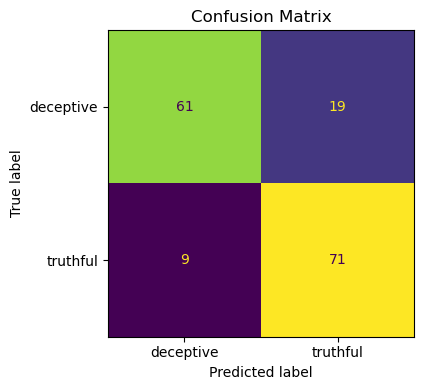

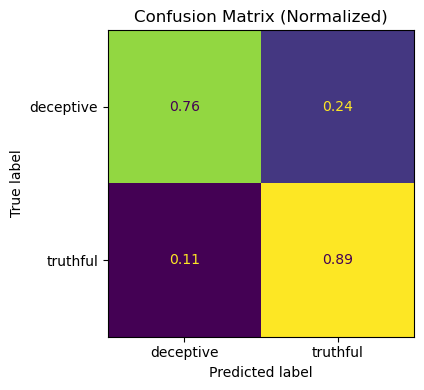

[saved] rf_uni_outputs/rf_unibi_confusion_counts.png
[saved] rf_uni_outputs/rf_unibi_confusion_counts.csv
[saved] rf_uni_outputs/rf_unibi_confusion_normalized.png


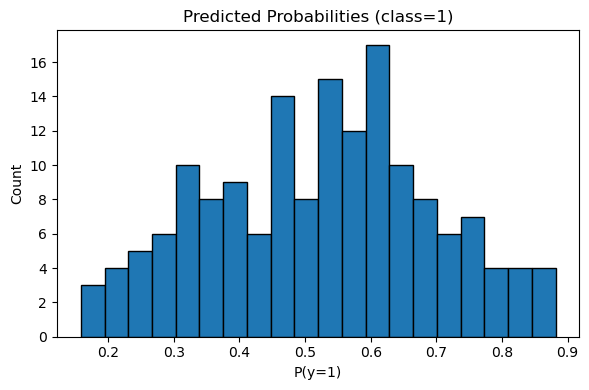

[saved] rf_uni_outputs/rf_unibi_prob_hist.png
[saved] rf_uni_outputs/rf_unibi_prob_hist.csv


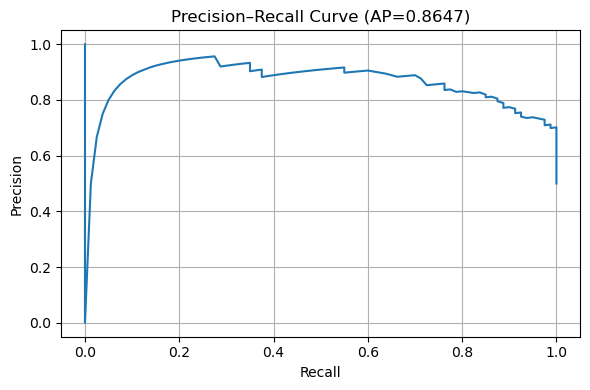

[saved] rf_uni_outputs/rf_unibi_pr.png
[saved] rf_uni_outputs/rf_unibi_pr.csv


In [ ]:
def main(argv=None):
    ap = argparse.ArgumentParser()
    ap.add_argument(
        "--data",
        default="/home/izujia/Desktop/Data Mining/AssigmentFiles/RF_GB",
        help="/home/izujia/Desktop/Data Mining/AssigmentFiles/RF_GB"
    )
    ap.add_argument("--outdir", default="./rf_uni_outputs")
    ap.add_argument("--k", type=int, default=3000, help="SelectKBest cap for features")
    args = ap.parse_args([] if argv is None else argv)

    data_path = Path(args.data)
    out_dir = Path(args.outdir); out_dir.mkdir(parents=True, exist_ok=True)

    root = data_path / "op_spam_v1.4" if (data_path / "op_spam_v1.4").is_dir() else data_path
    is_zip = zipfile.is_zipfile(root)
    print(f"Mode: {'ZIP' if is_zip else 'FOLDER'} | Root={root} | Polarity subset={sorted(POLS)}")

    df = load_dataframe(data_path)
    tr = df[df["fold"].isin([1, 2, 3, 4])].reset_index(drop=True)
    te = df[df["fold"].isin([5])].reset_index(drop=True)

    Xtr_uni, Xte_uni, feat_uni = vectorize_and_select(
        tr["text"].tolist(), te["text"].tolist(), tr["label"].values, k=args.k, ngram=(1, 1), min_df=2
    )
    best_uni = tune_rf_oob(Xtr_uni, tr["label"].values)
    test_uni = eval_on_test(best_uni["model"], Xte_uni, te["label"].values)

    save_classification_report(te["label"].values, test_uni["y_pred"], out_dir, fname="rf_uni_classification_report.txt")
    plot_and_save_confusion(te["label"].values, test_uni["y_pred"], out_dir, base="rf_uni_confusion")
    plot_prob_histogram(best_uni["model"], Xte_uni, out_dir, base="rf_uni_prob_hist")

    fake_uni, genuine_uni = directional_top_terms(best_uni["model"], Xtr_uni, tr["label"].values, feat_uni, topk=10)

    metrics_uni = pd.DataFrame([{
        "Model": "RF (unigrams)",
        "acc": round(test_uni["acc"], 4),
        "precision": round(test_uni["precision"], 4),
        "recall": round(test_uni["recall"], 4),
        "f1": round(test_uni["f1"], 4),
        "OOB": round(best_uni["oob"], 4)
    }])
    imp_uni_df = pd.DataFrame(fake_uni, columns=["Fake term","importance","direction(P1-P0)"]).join(
        pd.DataFrame(genuine_uni, columns=["Genuine term","importance_g","direction_g"]), how="outer"
    )

    metrics_uni_path = out_dir / "rf_uni_metrics.csv"
    imp_uni_path = out_dir / "rf_uni_top_terms.csv"
    pred_uni_path = out_dir / "rf_uni_test_predictions.csv"

    metrics_uni.to_csv(metrics_uni_path, index=False)
    imp_uni_df.to_csv(imp_uni_path, index=False)
    pd.DataFrame({"path": te["path"].values, "true_label": te["label"].values,
                  "pred": test_uni["y_pred"]}).to_csv(pred_uni_path, index=False)

    if hasattr(best_uni["model"], "predict_proba"):
        y_scores_uni = best_uni["model"].predict_proba(Xte_uni)[:, 1]
        plot_precision_recall(te["label"].values, y_scores_uni, out_dir, base="rf_uni_pr")
    lc_rf_uni = RandomForestClassifier(**best_uni["params"], bootstrap=True, oob_score=True,
                                       n_jobs=-1, random_state=42)
    plot_learning_curve_estimator(lc_rf_uni, Xtr_uni, tr["label"].values, out_dir, base="rf_uni_learning_curve")

    print(metrics_uni.to_string(index=False))
    print("\nTop terms (unigrams):\n", imp_uni_df.head(20).to_string(index=False))
    print(f"\nSaved (unigrams):\n  {metrics_uni_path}\n  {imp_uni_path}\n  {pred_uni_path}")

    Xtr_unibi, Xte_unibi, feat_unibi = vectorize_and_select(
        tr["text"].tolist(), te["text"].tolist(), tr["label"].values, k=args.k, ngram=(1, 2), min_df=2
    )
    best_unibi = tune_rf_oob(Xtr_unibi, tr["label"].values)
    test_unibi = eval_on_test(best_unibi["model"], Xte_unibi, te["label"].values)

    save_classification_report(te["label"].values, test_unibi["y_pred"], out_dir,
                               fname="rf_unibi_classification_report.txt")
    plot_and_save_confusion(te["label"].values, test_unibi["y_pred"], out_dir, base="rf_unibi_confusion")
    plot_prob_histogram(best_unibi["model"], Xte_unibi, out_dir, base="rf_unibi_prob_hist")


    fake_unibi, genuine_unibi = directional_top_terms(best_unibi["model"], Xtr_unibi, tr["label"].values, feat_unibi, topk=10)
    imp_unibi_df = pd.DataFrame(fake_unibi, columns=["Fake term","importance","direction(P1-P0)"]).join(
        pd.DataFrame(genuine_unibi, columns=["Genuine term","importance_g","direction_g"]), how="outer"
    )

    metrics_unibi = pd.DataFrame([{
        "Model": "RF (uni+bi)",
        "acc": round(test_unibi["acc"], 4),
        "precision": round(test_unibi["precision"], 4),
        "recall": round(test_unibi["recall"], 4),
        "f1": round(test_unibi["f1"], 4),
        "OOB": round(best_unibi["oob"], 4)
    }])

    metrics_unibi_path = out_dir / "rf_unibi_metrics.csv"
    imp_unibi_path = out_dir / "rf_unibi_top_terms.csv"
    pred_unibi_path = out_dir / "rf_unibi_test_predictions.csv"
    metrics_unibi.to_csv(metrics_unibi_path, index=False)
    imp_unibi_df.to_csv(imp_unibi_path, index=False)
    pd.DataFrame({"path": te["path"].values, "true_label": te["label"].values,
                  "pred": test_unibi["y_pred"]}).to_csv(pred_unibi_path, index=False)

    if hasattr(best_unibi["model"], "predict_proba"):
        y_scores_unibi = best_unibi["model"].predict_proba(Xte_unibi)[:, 1]
        plot_precision_recall(te["label"].values, y_scores_unibi, out_dir, base="rf_unibi_pr")
    lc_rf_unibi = RandomForestClassifier(**best_unibi["params"], bootstrap=True, oob_score=True,
                                         n_jobs=-1, random_state=42)
    plot_learning_curve_estimator(lc_rf_unibi, Xtr_unibi, tr["label"].values, out_dir, base="rf_unibi_learning_curve")

    print(metrics_unibi.to_string(index=False))
    print("\nTop terms (uni+bi):\n", imp_unibi_df.head(20).to_string(index=False))
    print(f"\nSaved (uni+bi):\n  {metrics_unibi_path}\n  {imp_unibi_path}\n  {pred_unibi_path}")

    both = pd.concat([metrics_uni, metrics_unibi], ignore_index=True)
    both.to_csv(out_dir / "rf_uni_vs_unibi_metrics.csv", index=False)
    print(f"\n[saved] {out_dir / 'rf_uni_vs_unibi_metrics.csv'}")

if __name__ == "__main__":
    main()